# Описание проекта
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

# Задачи
Выявить наиболее перспективные платформы для издания игр. 

Найти наиболее популярные жанры. 

Сделать прогноз о том как достигнуть наибольшей популярности продукта (игры). 

Выявить влияние оценок критиков и оценок игроков на продажи.

Проверить гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action и Sports разные.

# Импорт библиотек

In [1]:
import pandas as pd
pd.set_option('display.max_columns',None) # Убираем ограничение с ширины отображаемой таблицы
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

# Первичный осмотр

**Описание данных:**

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Прочитаем таблицу, и посмотрим её краткое описание с помощью функций `info()` и `describe()`.

In [2]:
games = pd.read_csv('games.csv')
print(games.info())
display(games.describe().transpose())
games.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


,count,mean,std,min,25%,50%,75%,max
Year_of_Release,16446.0,2006.484616,5.877050,1980.0,2003.0,2007.00,2010.00,2016.00
NA_sales,16715.0,0.263377,0.813604,0.0,0.0,0.08,0.24,41.36
EU_sales,16715.0,0.145060,0.503339,0.0,0.0,0.02,0.11,28.96
JP_sales,16715.0,0.077617,0.308853,0.0,0.0,0.00,0.04,10.22
Other_sales,16715.0,0.047342,0.186731,0.0,0.0,0.01,0.03,10.57
Critic_Score,8137.0,68.967679,13.938165,13.0,60.0,71.00,79.00,98.00


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Из чего можно увидеть следующее:
* В столбцах **Name** и **Genre** отсутсвуют по два значения, скорее всего это одни и те же строчки;
* Есть несколько отсутсувующих значений в **Year_of_Release**;
* Множество отсутсвующих значений в **Critic_Score**, **User_Score** и **Rating**, которые часто распологаются в одной и той же строчке;
* В числовых значениях всё в пределах нормы.

# Обработка данных

## Названия столбцов

In [3]:
games.columns = games.columns.str.lower() # переводим названия колонок в змеиный формат

## Заполнение пропусков

Посмотрим на проблемы замеченные ранее.
* *В столбцах **Name** и **Genre** отсутсвуют по два значения, скорее всего это одни и те же строчки;*

In [4]:
games[games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Действительно, это оказались одни и те же строчки. Поскольку эти игры довольно старые их можно просто убрать.

In [5]:
games.dropna(subset=['name'], inplace=True)

* *Есть несколько отсутсувующих значений в **Year_of_Release**;*

Посмотрим какие это строчки.

In [6]:
games[games['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Проверим не упоминается ли игра с отсутсвующей датой в таблице ещё раз.

In [7]:
games[games['name'] == 'FIFA Soccer 2004']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
2606,FIFA Soccer 2004,XB,2003.0,Sports,0.24,0.49,0.00,0.05,82.0,8.2,E
12029,FIFA Soccer 2004,GC,2003.0,Sports,0.05,0.01,0.00,0.00,83.0,6.2,E
13086,FIFA Soccer 2004,GBA,2003.0,Sports,0.04,0.01,0.00,0.00,82.0,7.9,E


Видно, что у одной и той же игры может отсутсвовать дата релиза для одной из платформ. Как правило год релиза на всех платформах совпадает (но не всегда). Для случаев где он не совпадает возьмем среднее арифметическое годов выпуска на других платформах, а после округлим до целого.

Руководствуясь этим заполним пропуски.

In [8]:
print('Пропусков до =', games['year_of_release'].isna().sum())
games['year_of_release'].fillna(games.groupby('name')['year_of_release'].transform(lambda x: x.mean()), inplace=True) # заполняем пустые значения средними для данной игры
games['year_of_release'] = games[games['year_of_release'].notna()]['year_of_release'].round() # округляем
print('Пропусков после =', games['year_of_release'].isna().sum())

Пропусков до = 269
Пропусков после = 146


Осталось 146 пустых значений. С ними уже ничего не поделаешь, вывести их из других значений не представляется возможным. Но, чтобы не терять их вклад в свой жанр, следует их оставить. Пустое значение заменим на -1.

In [9]:
games['year_of_release'].fillna(-1, inplace=True)
games['year_of_release'] = games['year_of_release'].astype(int)
print('Итого пропусков =', games['year_of_release'].isna().sum())

Итого пропусков = 0


* *Множество отсутсвующих значений в **Critic_Score**, **User_Score** и **Rating**, которые часто распологаются в одной и той же строчке;*

Сразу можно отметить, что помимо пропусков в **User_Score** имеются неопределенные значения `tbd`. Посмотрим на них.

In [10]:
games[games['user_score'] == 'tbd'].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,-1,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E


Учитывая, что `tbd` означает to be determined, можно предположить, что так отмечены игры, для которых оценка игроков ещё не была определена (что странно, игры то старые даже для 2016 года). Для нас же они несут столько же смысловой нагузки, сколько пустые значения. Поэтому для избежания дальнейшей путаницы заменим `tbd` на пустые значения.

In [11]:
games['user_score'].replace('tbd', np.nan, inplace=True)
games['user_score'] = games['user_score'].astype(float) # для дальнейших расчетов необходимо сменить тип на float

Пустые значения в **critic_score** и **user_score** заменим на среднюю оценку для этой игры на других платформах, с округлением до целого и до десятой соответсвенно. Значение **rating** для одной игры на разных платформах варьироваться не должно, так что можно просто заменить на моду.

In [12]:
for i in ['critic_score', 'user_score']:
    print('Пропусков в', i, 'до =', games[i].isna().sum())
    games[i].fillna(games.groupby('name')[i].transform(lambda x: x.mean()), inplace=True) # заполняем пустые значения средними для данной игры
    print('Пропусков в', i, 'после =', games[i].isna().sum())
games['critic_score'] = games[games['critic_score'].notna()]['critic_score'].round() # округляем
games['user_score'] = games[games['user_score'].notna()]['user_score'].round(1) # округляем
print('Пропусков в rating до =', games['rating'].isna().sum())
games['rating'].fillna(games.groupby('name')['rating'].transform(lambda x: x.dropna().mode()[0] if len(x.dropna().mode()) >= 1 else x.mode(dropna=False)[0]), inplace=True) 
# заполняем пустые значения модой, из-за того что мода порой выдает пустой список вводим условие по длине списка.
print('Пропусков в rating после =', games['rating'].isna().sum())

Пропусков в critic_score до = 8576
Пропусков в critic_score после = 7615
Пропусков в user_score до = 9123
Пропусков в user_score после = 8024
Пропусков в rating до = 6764
Пропусков в rating после = 6327


Достоверно заполнить оставшиеся пропуски не продоставляется возможным.

## Суммарные продажи
Создадим столбец с суммарным количеством проданных копий игры.

In [13]:
games['tot_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,tot_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Расчеты проведены корректно.

# Исследовательский анализ данных

## Количество игр по годам

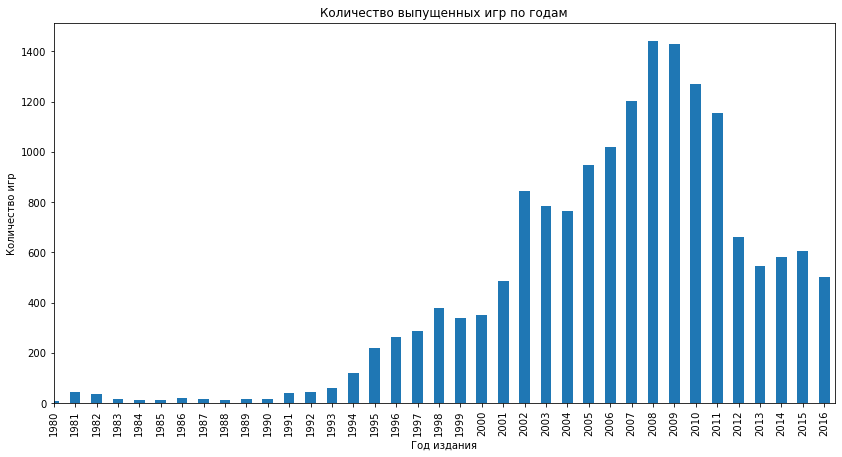

In [14]:
games.groupby('year_of_release')['name'].count().plot(kind='bar', figsize=(14, 7))
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Год издания')
plt.ylabel('Количество игр')
plt.xlim(left=1)
plt.show()

Виден рост количества игр начиная с 1994 года. Так что наиболее важным периодом можно назвать период с 1994 года включительно. Его и примем за **актуальный период**.

Рост достигает пика в 2008 году, затем количество игр идет на спад.

Далее работа будет проводиться только с данными для актуального периода.

In [15]:
games = games.query('year_of_release >= 1994')

## Количество игр по платформам и годам

Возьмем 5 наиболее платформ с самым большим количеством игр.

PS2     2140
DS      2128
PS3     1320
Wii     1301
X360    1250
Name: platform, dtype: int64


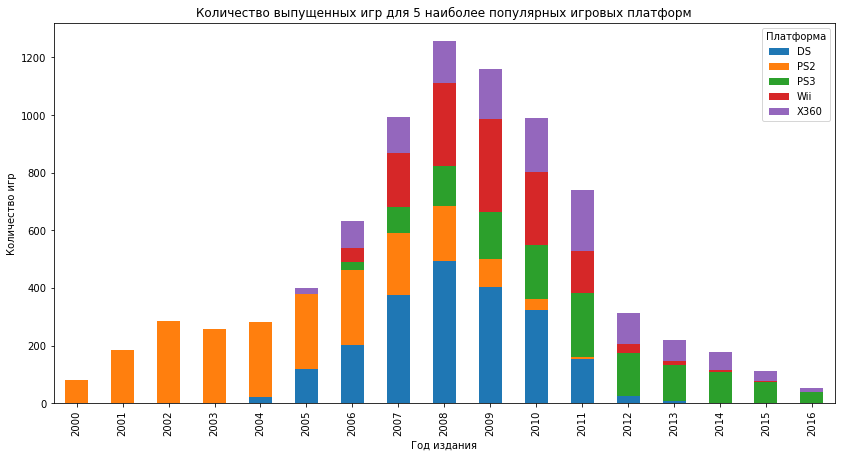

In [16]:
top_5_platforms = games['platform'].value_counts()[0:5]
print(top_5_platforms)
top_5 = games.query('platform in @top_5_platforms.index').pivot_table(index='year_of_release', columns='platform', values='name', aggfunc='count')
top_5.plot(kind='bar', figsize=(14, 7), stacked=True)
plt.title('Количество выпущенных игр для 5 наиболее популярных игровых платформ')
plt.xlabel('Год издания')
plt.ylabel('Количество игр')
plt.legend(title='Платформа')
plt.show()

Из чего видно, что для трех из этих платформ срок жизни составил
* для PS2 с 2000 по 2011 - 11 лет;
* для DS с 2004  по 2012 - 8 лет;
* для Wii с 2006 по 2014 - 8 лет.

Срок жизни двух других платформ, судя по спаду количества выходящих игр, подходит к концу.
* X360 с 2005 по 2016 - 11 лет
* PS3 с 2006 по 20016 - 10 лет

Средний срок жизни популярных платформ, таким образом, составлет приблизительно 10 лет.

## Лидеры 2016 года

Для определения перспективных лидеров 2016 года, воспользуемся графиком схожим с предыдущим.

PS4     164
XOne     87
PSV      85
PC       54
3DS      46
Name: platform, dtype: int64


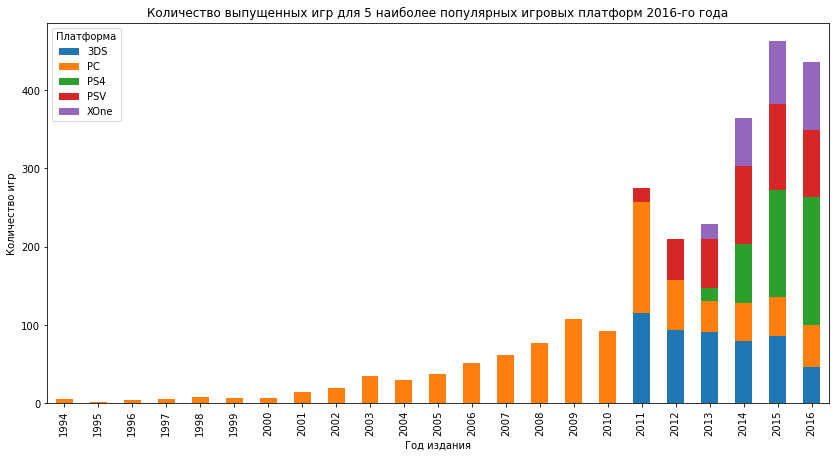

In [17]:
top_5_platforms_2016 = games.query('year_of_release == 2016')['platform'].value_counts()[0:5] # 5 платформ с наибольшим количесвом игр в 2016 году
print(top_5_platforms_2016)
top_5_2016 = games.query('platform in @top_5_platforms_2016.index').pivot_table(index='year_of_release', columns='platform', values='name', aggfunc='count')
top_5_2016.plot(kind='bar', figsize=(14, 7), stacked=True)
plt.title('Количество выпущенных игр для 5 наиболее популярных игровых платформ 2016-го года')
plt.xlabel('Год издания')
plt.ylabel('Количество игр')
plt.legend(title='Платформа')
plt.show()

Из чего видно, что наиболее "цветущими" являются платформы PS4 и XOne. Они обе зародились в 2013 году, и, скорее всего их ожидает рост в последующие годы.

PSV зародилась в 2011 году, то есть раньше чем PS4 и XOne а значит скорее всего её ожидает не столь выраженный рост.

3DS выглядит довольно необычно из-за большого количества игр в самом начале своего существования. Однако, количество игр постепенно идет на спад.

PC, из-за своего долгого существования, является необычной платформой. И она не подчиняется закономерностям по которым существуют другие платформы. Можно лишь заметить, что на этой платформе ежегодно выходит довольно значимое количество игр.

Таким образом наиболее перспективными платформами 2016 года можно назвать **PS4** и **XOne**.

## Boxplot
Построим Boxplot количества проданных копий для 5 платформ с наибольшим количеством вышедших в 2016 году игр.

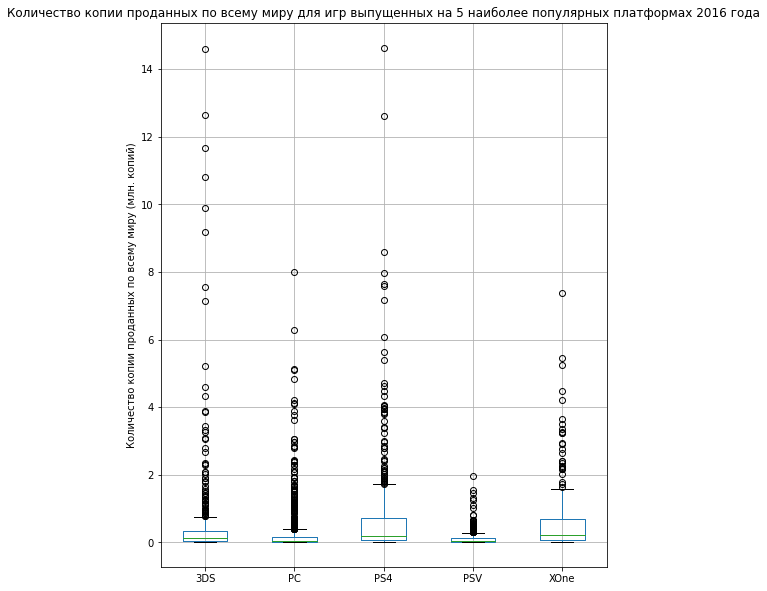

In [18]:
games.query('platform in @top_5_platforms_2016.index')[['platform', 'tot_sales']].groupby('platform').boxplot(subplots=False, figsize=(8,10))
plt.title('Количество копии проданных по всему миру для игр выпущенных на 5 наиболее популярных платформах 2016 года')
plt.ylabel('Количество копии проданных по всему миру (млн. копий)')
plt.xticks(ticks=[1, 2, 3, 4, 5],labels=['3DS', 'PC', 'PS4', 'PSV', 'XOne'])
plt.show()

Из более широких и больше уходящих вверх ящиков для PS4 и XOne (и более высоко достающих усов) видно, что платформами стабильно имеющими большее число продаж являются **PS4** и **XOne**.

## Scatterplot

Для постройки диаграммы рассеяния выберем PS4.

              tot_sales  critic_score
tot_sales      1.000000      0.391644
critic_score   0.391644      1.000000


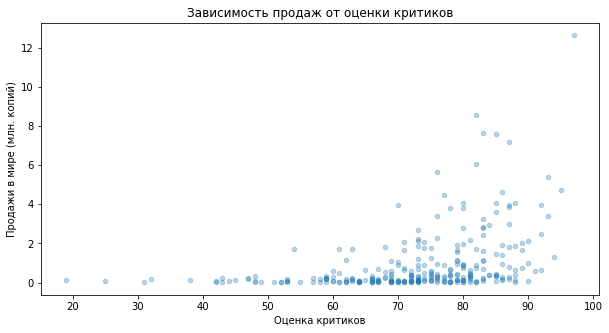

In [19]:
ps4 = games.query('platform == "PS4"')
print(ps4[['tot_sales', 'critic_score']].corr())
ps4.plot(kind='scatter', x='critic_score', y='tot_sales', alpha=0.3, figsize=(10, 5))
plt.title('Зависимость продаж от оценки критиков')
plt.ylabel('Продажи в мире (млн. копий)')
plt.xlabel('Оценка критиков')
plt.show()

            tot_sales  user_score
tot_sales    1.000000   -0.021589
user_score  -0.021589    1.000000


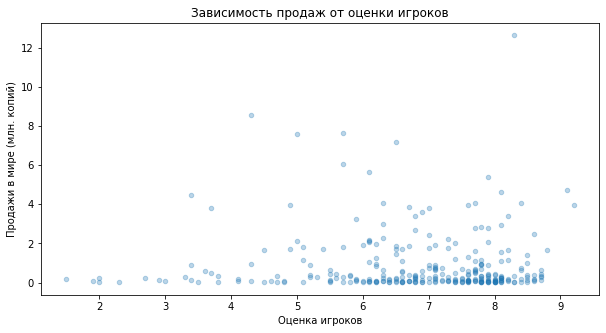

In [20]:
print(ps4[['tot_sales', 'user_score']].corr())
ps4.plot(kind='scatter', x='user_score', y='tot_sales', alpha=0.3, figsize=(10, 5))
plt.title('Зависимость продаж от оценки игроков')
plt.ylabel('Продажи в мире (млн. копий)')
plt.xlabel('Оценка игроков')
plt.show()

Итого как по самим диаграммам рассеяния, так и по коэффициенту корреляции видно, что оценки критиков имеют значительно более выраженное прямое воздействие на продажи игры.

## Жанры
Построим боксплоты для всех жанров.

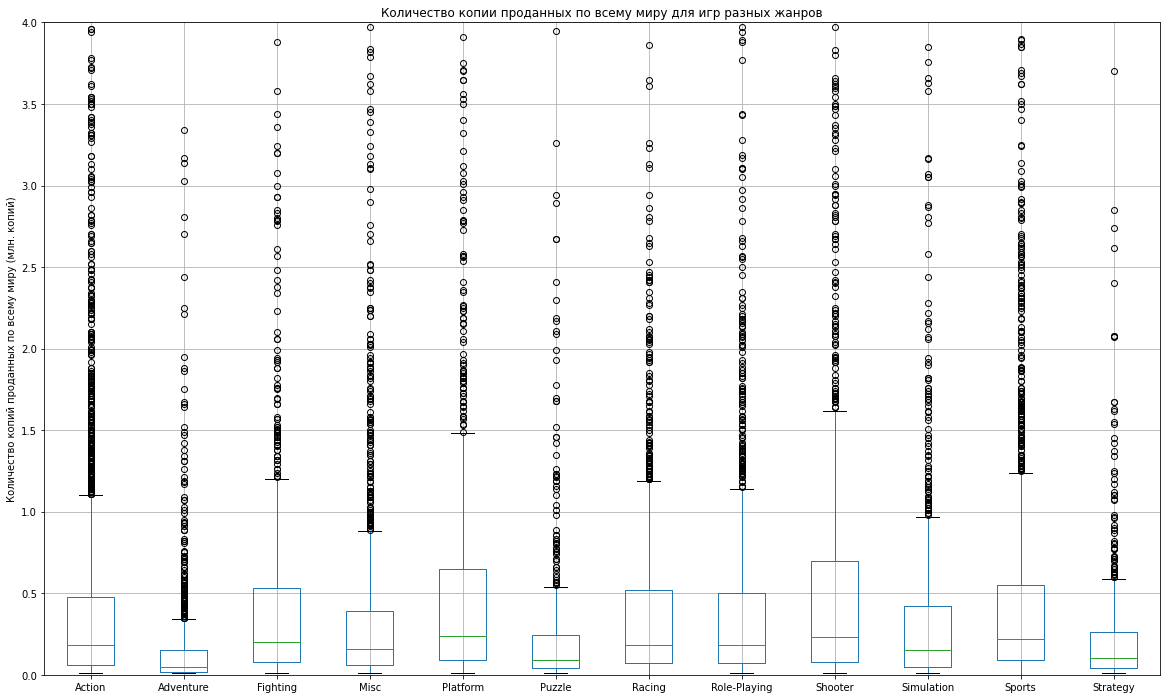

In [21]:
games[['genre', 'tot_sales']].groupby('genre').boxplot(subplots=False, figsize=(20, 12))
plt.xticks(ticks=range(1, 13),labels=['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle', 'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports', 'Strategy'])
plt.title('Количество копии проданных по всему миру для игр разных жанров')
plt.ylabel('Количество копий проданных по всему миру (млн. копий)')
plt.ylim((0, 4))
plt.show()

Из чего видно, что лидерами по продажам среди жанров являются:
* Шутеры;
* Платформеры;
* Игры про спорт.

Наименее продаваемые игры это:
* Приключенческие игры;
* Паззлы;
* Стратегии.

# Портрет пользователя каждого региона

## Платформы
Создадим таблицы с 5-ю самыми популярными платформами в различных регионах.

In [22]:
top_5_platforms_na = games.groupby('platform')['na_sales'].sum().sort_values(ascending=False)[:5]
top_5_platforms_eu = games.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)[:5]
top_5_platforms_jp = games.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)[:5]
top_platforms = pd.DataFrame([top_5_platforms_na, top_5_platforms_eu, top_5_platforms_jp])
top_platforms_total = games.query('platform in @top_platforms.columns').groupby('platform')['tot_sales'].sum()

Для наглядности соберем их в одну столбчатую диаграмму.

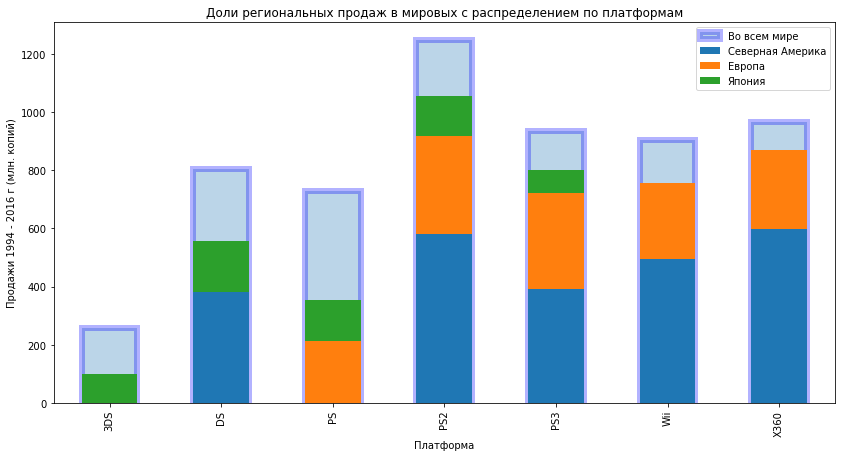

In [23]:
ax = top_platforms_total.sort_index().plot(kind='bar', figsize=(14, 7), edgecolor='b', linewidth=6, alpha=0.3, legend=True)
top_platforms.transpose().sort_index().plot(kind='bar', figsize=(14, 7), stacked=True, ax=ax)
plt.title('Доли региональных продаж в мировых с распределением по платформам')
plt.legend(['Во всем мире', 'Северная Америка', 'Европа', 'Япония'])
plt.ylabel('Продажи 1994 - 2016 г (млн. копий)')
plt.xlabel('Платформа')
plt.show()

В Северной Америке лидирующими платформами являются X360, PS2 и Wii. Причем продажи игр для платформы X360 и Wii в Америке составляют более половины от всемирных продаж для данных платформ.

В Европе лидирующие позиции занимают PS2, PS3 и X360.

В Японии DS, PS и PS2.

Самую большую долю рынка для наиболее поплярных платформ составляют покупатели из Северной Америки.

## Жанры
Аналогичное проделаем и для жанров.

In [24]:
top_5_genres_na = games.groupby('genre')['na_sales'].sum().sort_values(ascending=False)[:5]
top_5_genres_eu = games.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)[:5]
top_5_genres_jp = games.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)[:5]
top_genres = pd.DataFrame([top_5_genres_na, top_5_genres_eu, top_5_genres_jp])
top_genres_total = games.query('genre in @top_genres.columns').groupby('genre')['tot_sales'].sum()

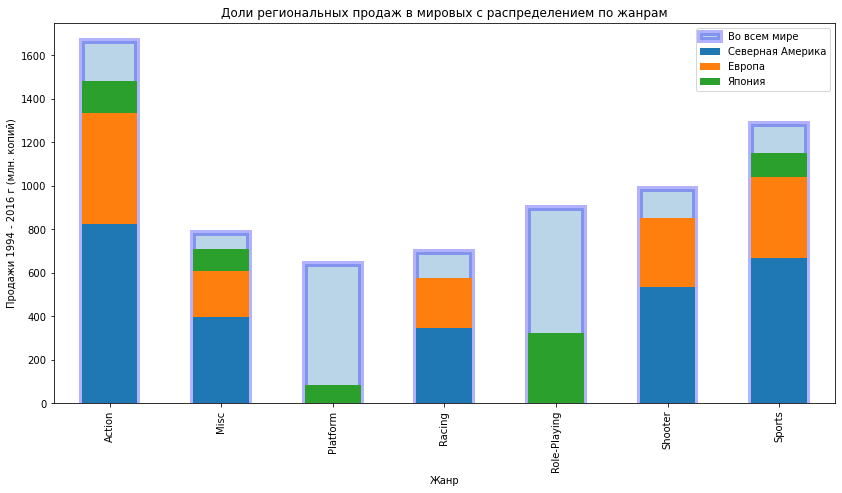

In [25]:
ax = top_genres_total.sort_index().plot(kind='bar', figsize=(14, 7), edgecolor='b', linewidth=6, alpha=0.3, legend=True)
top_genres.transpose().sort_index().plot(kind='bar', figsize=(14, 7), stacked=True, ax=ax)
plt.title('Доли региональных продаж в мировых с распределением по жанрам')
plt.legend(['Во всем мире', 'Северная Америка', 'Европа', 'Япония'])
plt.ylabel('Продажи 1994 - 2016 г (млн. копий)')
plt.xlabel('Жанр')
plt.show()

В Северной Америке лидирующие жанры: Экшен, Игры про спорт, Шутеры. Ровно как и в Европе.

В Японии Ролевые игры лидируют над Экшеном и Спортивными играми.

Опять таки Северная Америка имеет наибольшую долю продаж.

## Влияние рейтинга ESRB
Для начала посмотрим какие типы рейтингов встречаются чаще всего.

In [26]:
games['rating'].value_counts()

E       4113
T       3056
M       1642
E10+    1457
EC        10
K-A        4
RP         2
AO         1
Name: rating, dtype: int64

Получается это рейтинги: E, T, M, E10+.

In [27]:
frequent_ratings = games['rating'].value_counts().index[:4]
ratings = games.query('rating in @frequent_ratings').groupby('rating')[['na_sales', 'eu_sales', 'jp_sales', 'tot_sales']].sum()

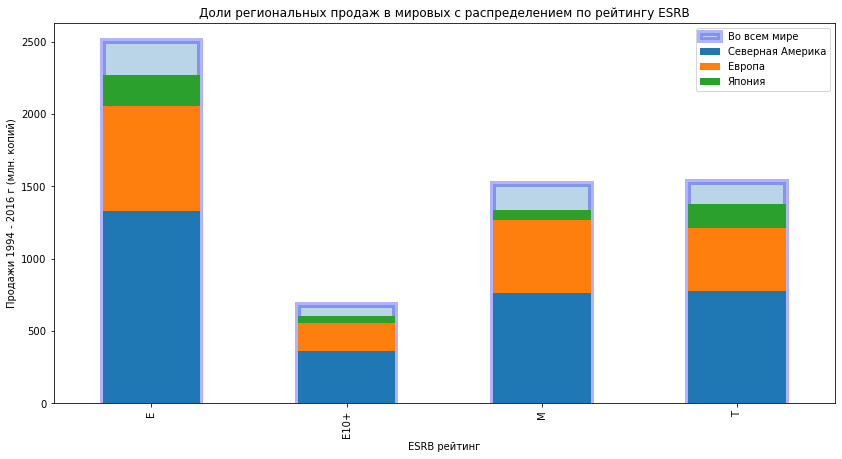

In [28]:
ax = ratings['tot_sales'].plot(kind='bar', figsize=(14, 7), edgecolor='b', linewidth=6, alpha=0.3, legend=True)
ratings[['na_sales', 'eu_sales', 'jp_sales']].plot(kind='bar', figsize=(14, 7), stacked=True, ax=ax)
plt.title('Доли региональных продаж в мировых с распределением по рейтингу ESRB')
plt.ylabel('Продажи 1994 - 2016 г (млн. копий)')
plt.xlabel('ESRB рейтинг')
plt.legend(['Во всем мире', 'Северная Америка', 'Европа', 'Япония'])
plt.show()

Из чего видно, доли продаж каждого региона для игр различного ESRB рейтинга остаются приблизительно постоянными. Значит этот рейтинг не влияет на продажи в отдельном регионе.

# Проверка гипотез

## Гипотеза о разнице средних пользовательских рейтингов Xbox One и PC
Сформулируем нулевую гипотезу: Средние пользовательские рейтинги для игр на платформах Xbox One и PC одинаковы.

Альтернативная гипотеза: Средние пользовательские рейтинги для игр на платформах Xbox One и PC различны.

Пороговым значением p-критерия значимости будет значение в 0.05.

In [29]:
Xone = games.query('platform == "XOne"')['user_score'].dropna()
PC = games.query('platform == "PC"')['user_score'].dropna()

Для начала посмотрим на распределения пользоватеьских рейтингов для обеих платформ.

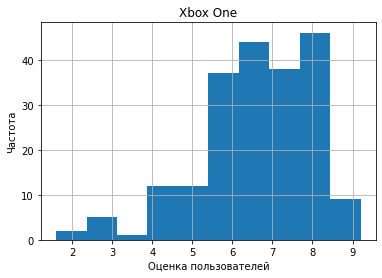

In [30]:
Xone.hist(bins=10)
plt.title('Xbox One')
plt.ylabel('Частота')
plt.xlabel('Оценка пользователей')
plt.show()

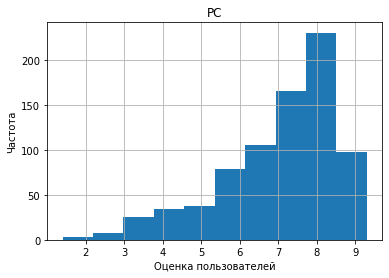

In [31]:
PC.hist(bins=10)
plt.title('PC')
plt.ylabel('Частота')
plt.xlabel('Оценка пользователей')
plt.show()

Эти распределения не очень похожи на нормальные. Поэтому для сравнения их дисперсий воспользуемся тестом Левена.

Нулевая гипотеза для теста Левена: Дисперсии генеральных совокупностей для распределений пользовательских оценок обеих платформ равны. Пороговым значением критерия значимости назначим значение 0.05.

In [32]:
print('Дисперсия пользовательских оценок игроков на Xbox One =', Xone.var())
print('Дисперсия пользовательских оценок игроков на PC =', PC.var())
print('p-значение критерия Левена =', st.levene(Xone, PC).pvalue)

Дисперсия пользовательских оценок игроков на Xbox One = 1.8993466729812933
Дисперсия пользовательских оценок игроков на PC = 2.304789500674493
p-значение критерия Левена = 0.3181495146466027


Поскольку p-значение критерия Левена = 0.3181495146466027 больше 0.05,  не отвергаем нулевую гипотезу о равенстве дисперсий, а значит дальнейший анализ проведем при помощи t-критерия для независимых выборок с одинаковой дисперсией.

In [33]:
print('Средняя пользовательская оценка игроков на Xbox One =', Xone.mean())
print('Средняя пользовательская оценка игроков на PC =', PC.mean())
print('p-значение t-критерия =', st.ttest_ind(Xone, PC).pvalue)

Средняя пользовательская оценка игроков на Xbox One = 6.604368932038832
Средняя пользовательская оценка игроков на PC = 7.067943805874853
p-значение t-критерия = 7.617977656599233e-05


Что меньше чем 0.05. А значет нулевая гипотеза может быть отвергнута в пользу альтернативной. Альтернативная гипотеза: Средние пользовательские рейтинги для игр на платформах Xbox One и PC различны.

## Гипотеза о разнице средних пользовательских рейтингов жанров Action и Sports
Сформулируем нулевую гипотезу: Средние пользовательские рейтинги для игр жанров Action и Sports одинаковы.

Альтернативная гипотеза: Средние пользовательские рейтинги для игр жанров Action и Sports различны.

Пороговым значением p-критерия значимости будет значение в 0.05.

In [34]:
action = games.query('genre == "Action"')['user_score'].dropna()
sports = games.query('genre == "Sports"')['user_score'].dropna()

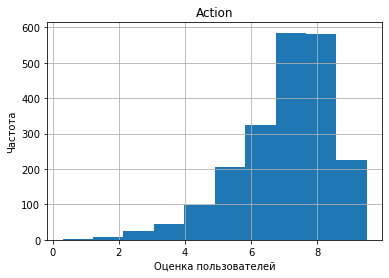

In [35]:
action.hist(bins=10)
plt.title('Action')
plt.ylabel('Частота')
plt.xlabel('Оценка пользователей')
plt.show()

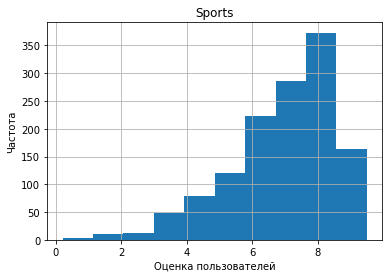

In [36]:
sports.hist(bins=10)
plt.title('Sports')
plt.ylabel('Частота')
plt.xlabel('Оценка пользователей')
plt.show()

Вновь распределения непохожи на нормальные, значит применим критерий Левена. Пороговым значением критерия значимости назначим значение 0.05.

In [37]:
print('Дисперсия пользовательских оценок игроков жанра Action =', action.var())
print('Дисперсия пользовательских оценок игроков жанра Sports =', sports.var())
print('p-значение критерия Левена =', st.levene(action, sports).pvalue)

Дисперсия пользовательских оценок игроков жанра Action = 1.998446829508449
Дисперсия пользовательских оценок игроков жанра Sports = 2.557978339225583
p-значение критерия Левена = 7.529851925889322e-06


Поскольку p-значение критерия Левена меньше 0.05, отвергнем нулевую гипотезу в пользу гипотезы о том, что дисперсии генеральных совокупностей различны. А значит для сравнения средних выручек воспользуемся t-критерием Уэлча.

In [38]:
st.ttest_ind(action, sports, equal_var=False)
print('Средняя пользовательская оценка игроков жанра Action =', action.mean())
print('Средняя пользовательская оценка игроков жанра Sports =', sports.mean())
print('p-значение t-критерия =', st.ttest_ind(action, sports, equal_var=False).pvalue)

Средняя пользовательская оценка игроков жанра Action = 7.02339209147211
Средняя пользовательская оценка игроков жанра Sports = 6.9232752084912725
p-значение t-критерия = 0.06273547277121157


Что больше чем 0.05. Значит, хоть значение и на грани, мы не отвергаем нулевую гипотезу о том, средние пользовательские рейтинги для игр жанров Action и Sports одинаковы.

# Вывод

1. Время жизни игровой плотформы состаляет около 10 лет. Расцвет приходится на 3 - 7 год.

---
2. Платформами с наибольшим количеством выпущенных до 2016 года игр являются: PlayStation2, Nintendo DS, PlayStation 3, Wii, Xbox 360.

В 2016 году платформы с наибольшим числом игр: PlayStation 4, Xbox One, PlayStaion Vita, PC, Nintendo 3DS.

Из чего видно, больше всего игр выходит для платформ принадлежащих компаниям: Sony Interactive Entertainment (PlayStation), Nintendo и Microsoft (Xbox).

---
3. Более высокое ожидаемое количество проданных копий в мире для игры в 2016 году принадлежит играм на платформах PlayStation 4 и Xbox One. Обе на 2016 год являются растущими платформами (им по 3 и 4 года стоответсвенно).

Жанры игр с наивысшими ожидаемыми продажами в мире с 1994 по 2016 год: шутеры, платформеры, игры про спорт.

Низкие ожидаемые продажи у игр жанров: приключенческие игры, паззлы, стратегии.

---
4. Для **PlayStation 4**.

Высокий рейтинг критиков положительно влияет на продажи.

Влияние рейтинга пользователей на продажи не прослеживается.

---
5. В Северной Америке наиболее популярным платформами до 2016 года являлись: Xbox 360, PlayStation 2 и Wii. Жанры: Экшен, Игры про спорт, Шутеры.

В Европе наиболее популярным платформами до 2016 года являлись: PlayStation 2, PlayStation 3 и Xbox 360. Жанры: Экшен, Игры про спорт, Шутеры.

В Японии наиболее популярным платформами до 2016 года являлись: Nintendo DS, PlayStation и PlayStation 2. Жанры: Ролевые игры, Экшен, Игры про спорт.

Самым большим потребителем игр является Северная Америка.

---
6. Влияние рейтинга ESRB на продажи одинаково во всех регионах.

---
7. Средняя оценка игры пользователей платформы Xbox One выше чем пользователей PC. Различие признано статистически значимым.

Гипотеза о равенстве пользовательских оценок игр жанров экшен и спортивных симуляторов не может быть отвергнута.

---
**Общий вывод**

С точки зрения объемов продаж наиболее перспективной платформой является PlayStation (любое поколение), так как во всех регионах она практически в любое время входит в списки самых популярных платформ. Однако, если расчитывать на самого крупного покупателя (Северную Америку), то также стоит сделать ставку и на Xbox.

Абсолютно точно не стоит выпускать игру жанра паззл, стратегия или приключенческую. Лучше сконцентрироваться на таких жанрах как: экшен, шутеры и спортивные симуляторы (или ролевые игры для Японии).

Для бóльших продаж стоит побеспокоиться о том, чтобы критики высоко оценили игру. ;-)

Лучше всего выпускать игры для платформы которая на момент выпуска находится в стадии расцвета (3- 7 лет с момента появления на рынке).